# Experiment settings

In [1]:
epochs = 3
max_len = 128

# Experiment_name
experiment_name = 'basline_entire_dataset'

# Naming: model
model_path = 'model/' + experiment_name + '.pt'
print(model_path)

# Naming: training history
training_df_path = 'history/' + experiment_name + '.csv'
print(training_df_path)

model/basline_entire_dataset.pt
history/basline_entire_dataset.csv


# Using GPU

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
assert device_name == '/device:GPU:0'
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# import package and torch
!pip install --upgrade packaging --quiet
!pip install torch --quiet

In [4]:
import torch

assert torch.cuda.is_available()

# Tell torch to use GPU
device = torch.device("cuda")
print('Running GPU: {}'.format(torch.cuda.get_device_name()))

Running GPU: NVIDIA GeForce GTX 1080 Ti


# Import dataset

In [10]:
import numpy as np
import pandas as pd

# Load 78k dataset
df = pd.read_csv('data/78k_without_punc.csv')
#df.columns = ['class', 'text']

# Show number of data entries
print('Number of data entries: {}'.format(len(df)))

# Show a few samples
df.sample(3)

Number of data entries: 78056


,text,class
26117,胡锦涛希腊总统举行会谈 新华网雅典11月24日电 国家主席胡锦涛24日雅典希腊总统卡罗洛斯·...,时政
48595,权威分析半年房产市场持续回暖存确定性 半年房地产市场发展两大趋势房地产投资望继续反弹房价出现...,房产
69439,高法医生大量开药严重果将追究刑责 本报讯记者邱伟昨天高法院刑二庭对宽严相济刑事政策经济犯罪职...,时政


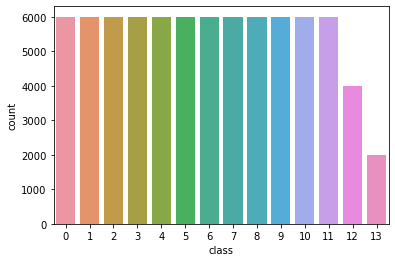

In [11]:
# Label Encdoing
class_map={'科技':0, '股票':1, '体育':2, '娱乐':3, '时政':4,
          '社会':5, '教育':6, '财经':7, '家居':8, '游戏':9,
          '房产':10, '时尚':11,'彩票':12, '星座':13}

# Mapping the class names
df['class'] = df['class'].map(class_map)

# Show class countplot
import seaborn as sns
sns.countplot(df['class'])

# Experiment settings
Using the entire 78k dataset for trianing

# Train, valid and test split

In [12]:
from sklearn.model_selection import train_test_split

# Extra 20% for testing
df_train, df_val = train_test_split(df,
                                    test_size=0.2,
                                    random_state=1,
                                    stratify=df['class'])

Shape: (62444, 2)
Shape: (15612, 2)


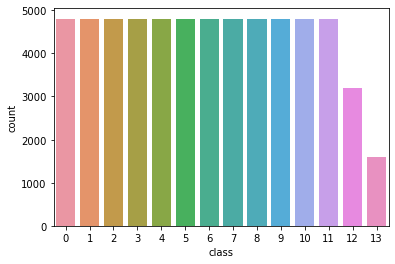

In [13]:
for item in df_train, df_val:
    print('Shape: {}'.format(item.shape))

# Show df_train class distribution    
sns.countplot(df_train['class'])

# Tokenization

In [14]:
!pip install transformers --quiet

ERROR: tensorlayer 2.1.0 has requirement numpy<1.17,>=1.16, but you'll have numpy 1.21.2 which is incompatible.


In [19]:
from transformers import BertTokenizer

# Load BERT tokenizer
model_name = 'bert-base-chinese'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [20]:
# Create lists for encoded text data
def get_encoded_dict(df):
    input_ids = []
    attention_mask = []

    for text in df['text']:
        encoded = tokenizer.encode_plus(text,
                                        add_special_tokens=True,
                                        padding='max_length',
                                        return_attention_mask=True,
                                        max_length=max_len,
                                        return_tensors='pt',
                                        truncation=True)

        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
        
    return input_ids, attention_mask

In [21]:
# Cat lists to tensors for TensorDataset
def get_tensors(input_ids, attention_mask):
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_mask = torch.cat(attention_mask, dim=0)
    
    return input_ids, attention_mask

# Dataset and DataLoader

In [22]:
# Import tools for Dataloader
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

# Convert df to DataLoader
def get_dataloader(df, batch_size=32):
    temp_ids, temp_masks = get_encoded_dict(df)
    
    # Convert to tensors
    temp_ids, temp_masks = get_tensors(temp_ids, temp_masks)
    temp_labels = torch.tensor(df['class'].values)
    
    # Generate dataset
    temp_dataset = TensorDataset(temp_ids,
                                 temp_masks,
                                 temp_labels)
    
    # Generate dataloader
    temp_dataloader = DataLoader(temp_dataset,
                                 batch_size=batch_size,
                                 sampler=RandomSampler(temp_dataset))
    
    return temp_dataloader

In [23]:
# Get dataloader for all dataframes
train_dataloader = get_dataloader(df_train)
val_dataloader = get_dataloader(df_val)

# Import BERT model

In [24]:
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=len(class_map),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

# Tell mode to use CUDA
model.cuda()

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [25]:
# Configuring optimizer
optimizer = AdamW(model.parameters(),
                  lr = 3e-5)

In [26]:
# Configuring scheduler
from transformers import get_linear_schedule_with_warmup

# Total steps: number of batchers * epochs
total_steps = len(train_dataloader) * epochs

# Set up the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=10,
                                            num_training_steps=total_steps)

# Training

In [27]:
# Import materics for evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import time

In [28]:
# Reset history lists
training_stats = []

for epoch_i in range(epochs):
    
    # timer_start
    epoch_t0 = time.time()
    
    print('【EPOCH: {}/ {}】'.format(epoch_i+1, epochs))
    print('Trainig Phase')
    
    # Set training mode
    model.train()
    
    # Reset training loss
    total_training_loss = 0.
    
    # Batch and forward
    for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        # Reset gradients before 
        model.zero_grad()
        
        # Forward pass
        res = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_masks,
                    return_dict=True,
                    labels=b_labels)
        
        loss = res.loss
        logits = res.logits
        
        # sumup training loss
        total_training_loss += loss.item()
        
        # backpropagation
        loss.backward()
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update optimizer and scheduler
        optimizer.step()
        scheduler.step()
        
    # averrage loss
    avg_train_loss = total_training_loss/len(train_dataloader)
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    
    
    # validation
    print('Validation Phase')
    
    # Reset validation loss
    total_val_loss = 0
    
    # Set up lists
    ls_val_logits = []
    ls_val_labels = []

    # Get batchs from val_dataloader
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        # No need to calculate gradients
        with torch.no_grad():

            res = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_masks,
                        labels=b_labels,
                        return_dict=True)

        val_loss = res.loss
        val_logits = res.logits
        total_val_loss += val_loss.item()

        # Convert logitis to numpy format
        val_logits = np.argmax(val_logits.cpu().detach().numpy(), axis=1)
        val_labels = b_labels.cpu().detach().numpy()

        # Append data to the lists
        for logit in val_logits:
            ls_val_logits.append(logit)

        for label in val_labels:
            ls_val_labels.append(label)
    
    # Get accuracy score and val_loss
    acc = accuracy_score(ls_val_logits, ls_val_labels)
    avg_val_loss = total_val_loss/len(val_dataloader)
    
    # Print out validation performance
    print('  Average validation loss: {:.4f}'.format(avg_val_loss))
    print('  Validation accruacy: {:.4f}'.format(acc))
    
    
    # timer_end
    epoch_time_spent = time.time() - epoch_t0
    print('  Time spent on the epoch: {:.2f}'.format(epoch_time_spent))
    print('\n')
    
    # Recording training stats
    training_stats.append(
        {
            'Epoch': epoch_i+1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_acc': acc,
            'time_spent': epoch_time_spent
        })

【EPOCH: 1/ 3】
Trainig Phase
  Average training loss: 0.2171
Validation Phase
  Average validation loss: 0.1274
  Validation accruacy: 0.9643
  Time spent on the epoch: 752.48


【EPOCH: 2/ 3】
Trainig Phase
  Average training loss: 0.0792
Validation Phase
  Average validation loss: 0.1217
  Validation accruacy: 0.9676
  Time spent on the epoch: 758.53


【EPOCH: 3/ 3】
Trainig Phase
  Average training loss: 0.0337
Validation Phase
  Average validation loss: 0.1196
  Validation accruacy: 0.9722
  Time spent on the epoch: 755.61




# Training and evaluation performance

In [33]:
train_loss = []
val_loss = []
val_acc = []
time_spent = []

for i in range(len(training_stats)):
    train_loss.append(training_stats[i]['train_loss'])
    val_loss.append(training_stats[i]['val_loss'])
    val_acc.append(training_stats[i]['val_acc'])
    time_spent.append(training_stats[i]['time_spent'])

Time spent on training 3 epochs: 38 minutes


Text(0.5, 1.0, 'accuracy')

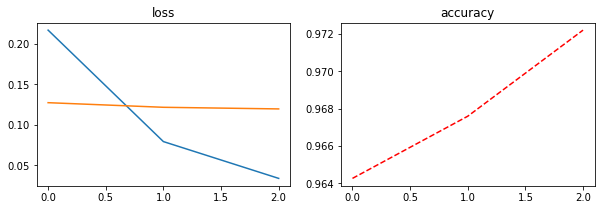

In [44]:
# Print time spent
print('Time spent on training {} epochs: {:.0f}'.format(epochs, np.sum(time_spent)/60) + ' minutes')

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('loss')

plt.subplot(1,2,2)
plt.plot(val_acc, color='red', linestyle='--')
plt.title('accuracy')

# Saving the model

In [46]:
torch.save(model.state_dict(), model_path)

# Perform on the test data

#### # Prepare test_dataloder from 125k dataset 

In [47]:
# Load 125k dataset
df_test = pd.read_csv('data/125k_without_punc.csv')
#df.columns = ['class', 'text']

# Show number of data entries
print('Number of data entries: {}'.format(len(df_test)))

# Mapping class to number
df_test['class'] = df_test['class'].map(class_map)

# Show a few samples
df_test.sample(3)

Number of data entries: 125412


,class,text
46431,2,麦蒂肩科奥尼说行 透露子学Tmac步伐新浪体育讯北京时间2月4日 火箭主场对阵公牛面对三巨头...
12997,5,餐馆按价钱决定菜顺序 老板称便宜菜利赚亚心网讯 记者 文慧 按理说餐馆吃饭应按照点菜顺序菜库...
43107,2,西班牙金童贵知明 巨大喜悦悲哀源重伤记者梁宏业报道 西班牙队球员逐走过金杯领取金牌时大多数都...


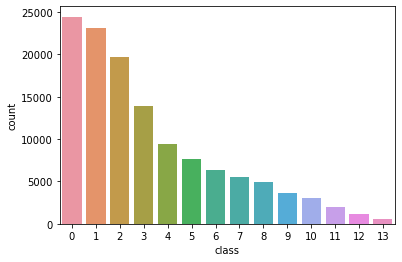

In [48]:
# Show df_test class disctribution
sns.countplot(df_test['class'])

In [49]:
# Timer_start
infer_t0 - time.time()

# Prepare df_test for prediction
t_input_ids, t_attention_mask = get_encoded_dict(df_test)
t_input_ids, t_attention_mask = get_tensors(t_input_ids, t_attention_mask)

# Prepare dataset and dataloader
test_dataset = TensorDataset(t_input_ids, t_attention_mask)
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             sampler=SequentialSampler(test_dataset))

# Show dataloader length
print('Number of batches in the dataloader: {}'.format(len(test_dataloader)))

Number of batches in the dataloader: 3920


In [50]:
# Setup lists for predictions and labels
ls_test_pred = []

# Get batchs from test_dataloader
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_masks = batch[1].to(device)
    
    with torch.no_grad():

        res = model(b_input_ids,
                    attention_mask=b_masks,
                    return_dict=True)

        test_logits = res.logits
        test_logits = np.argmax(test_logits.cpu().detach().numpy(), axis=1)
        
        for pred in test_logits:
            ls_test_pred.append(pred)
            
# Timer_end
time_spent = time.time() - infer_t0
print('Time spent on inferencing: {.0f}'.format(time_spent/60) + ' minutes')

In [51]:
# Set up list of test labels
ls_test_labels = list(df_test['class'].values)

# Get accuracy score and val_loss
acc = accuracy_score(ls_test_labels, ls_test_pred)
print('Prediction accuracy: {:.4f}'.format(acc))

Prediction accuracy: 0.8014


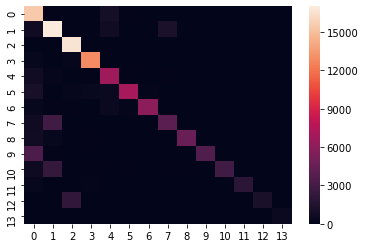

In [52]:
# Confusion matrix
cm = confusion_matrix(ls_test_pred, ls_test_labels)

sns.heatmap(cm)

In [53]:
# Classification report
cr = classification_report(ls_test_labels, ls_test_pred)

print(cr)

              precision    recall  f1-score   support

           0       0.93      0.64      0.75     24440
           1       0.86      0.73      0.79     23160
           2       0.99      0.84      0.91     19741
           3       0.95      0.93      0.94     13895
           4       0.83      0.71      0.76      9463
           5       0.75      0.92      0.83      7628
           6       0.82      0.96      0.89      6291
           7       0.52      0.72      0.60      5564
           8       0.78      0.95      0.86      4888
           9       0.49      0.97      0.65      3656
          10       0.46      0.97      0.62      3007
          11       0.76      0.98      0.86      2005
          12       0.33      1.00      0.49      1138
          13       0.95      0.95      0.95       536

    accuracy                           0.80    125412
   macro avg       0.74      0.88      0.78    125412
weighted avg       0.85      0.80      0.81    125412

